In [1]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-07-19 10:14:09.026845: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-19 10:14:10.398786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-19 10:14:11.061460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [2]:
import polars
import matplotlib.pyplot as plt
import torchaudio

import helpers.input_processor as ip

/home/andrecox/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = "data/raw_training/training_data/"
df = ip.ingest_data(data_dir)

Reading from .txt files in data/raw_training/training_data/: 100%|██████████| 942/942 [00:00<00:00, 12367.89it/s]


In [4]:
# output metadata of first audio file
metadata = torchaudio.info(data_dir + df['audio_file'][0][0])
print(metadata)

AudioMetaData(sample_rate=4000, num_frames=41152, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [5]:
# loop through the dataset and create a list of audio paths
audioPaths = []
labels = []
for i in range(len(df)):
    for j in range(len(df['audio_file'][i])):
        audioPaths.append(data_dir + df['audio_file'][i][j])
        # check if there is a murmur at the recording location
        murmur = False
        for k in df['murmur_locations'][i]:
            if k in df['audio_file'][i][j]:
                labels.append(1)
                murmur = True
                break
        if murmur == False:
            labels.append(0)



print("Audio path number: ", len(audioPaths))
print("Label number: ", len(labels))

Audio path number:  3163
Label number:  3163


In [6]:
import random
import sys
import copy

# make the positive's and negative's equal
num_pos = 0
num_neg = 0

for i in range(len(labels)):

    if labels[i] == 1:
        num_pos += 1
    else:
        num_neg += 1

balanced_labels = copy.deepcopy(labels)
balanced_audio_paths = copy.deepcopy(audioPaths)


while num_pos != num_neg:
    # get ratio of positive to negative
    ratio = (num_pos / num_neg) * 100.0

    sys.stdout.flush()
    sys.stdout.write("\rRatio: %s" % ratio + "%")

    if num_pos > num_neg:
        foundNeg = False
        while foundNeg == False:
            idx = random.randint(0, len(balanced_labels) - 1)
            if balanced_labels[idx] == 0:
                balanced_labels.append(0)
                balanced_audio_paths.append(balanced_audio_paths[idx])
                foundNeg = True
                num_neg += 1
    else:
        foundPos = False
        while foundPos == False:
            idx = random.randint(0, len(balanced_labels) - 1)
            if balanced_labels[idx] == 1:
                balanced_labels.append(1)
                balanced_audio_paths.append(balanced_audio_paths[idx])
                foundPos = True
                num_pos += 1


Ratio: 99.96246246246247%%

In [7]:
# check how many positive and negative examples are in the dataset
num_pos = 0
num_neg = 0
for i in range(len(balanced_labels)):
    if balanced_labels[i] == 1:
        num_pos += 1
    else:
        num_neg += 1

print("Positive examples: ", num_pos)
print("Negative examples: ", num_neg)
print("Total examples: ", num_pos + num_neg)

print("Percentage of positive examples: ", (num_pos / (num_pos + num_neg)) * 100.0, "%")

Positive examples:  2664
Negative examples:  2664
Total examples:  5328
Percentage of positive examples:  50.0 %


In [8]:
# split audio paths and labels into training and testing sets shuffled
import random
zipped = list(zip(balanced_audio_paths, balanced_labels))
random.shuffle(zipped)
shuffled_audio_paths, shuffled_labels = zip(*zipped)

train_audio_paths = shuffled_audio_paths[:int(len(shuffled_audio_paths) * 0.8)]
train_labels = shuffled_labels[:int(len(shuffled_labels) * 0.8)]

test_audio_paths = shuffled_audio_paths[int(len(shuffled_audio_paths) * 0.8):]
test_labels = shuffled_labels[int(len(shuffled_labels) * 0.8):]

In [9]:
print("Training audio paths: ", len(train_audio_paths))
print("Training labels: ", len(train_labels))
print("Testing audio paths: ", len(test_audio_paths))
print("Testing labels: ", len(test_labels))

Training audio paths:  4262
Training labels:  4262
Testing audio paths:  1066
Testing labels:  1066


In [10]:
import numpy as np
import torch
import torchaudio

def batch_generator(image_paths, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            ids_batch = image_paths[start:end]
            for id in ids_batch:
                waveform = torchaudio.load(id)[0]
                spectrogram = torchaudio.transforms.Spectrogram()(waveform)
                spectrogram = spectrogram.log2()
                spectrogram = spectrogram / spectrogram.abs().max()
                spectrogram = spectrogram[:200, :, :]
                if spectrogram.shape[0] < 200:
                    pad_width = (0, 201 - spectrogram.shape[2], 0, 0, 0, 0)
                    spectrogram = torch.nn.functional.pad(spectrogram, pad_width, 'constant', 0)
                spectrogram = spectrogram.numpy()
                x_batch.append(spectrogram.reshape(spectrogram.shape[1], spectrogram.shape[2]))
                y_batch.append(labels[image_paths.index(id)])

            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch


Time to generate batch:  147.76134490966797 ms


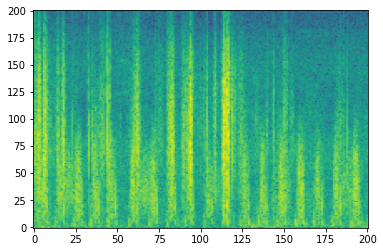

In [11]:
# display the first image and steering angle
import matplotlib.pyplot as plt
import time 
start = time.time()
x_batch, y_batch = next(batch_generator(train_audio_paths, train_labels, 32))
end = time.time()
print("Time to generate batch: ", (end - start) * 1000, "ms")
plt.imshow(x_batch[1], aspect='auto', origin='lower')

In [12]:
print(x_batch.shape)

(32, 201, 201)


In [13]:
batch_size = 32

train_gen = batch_generator(train_audio_paths, train_labels, batch_size=batch_size)
test_gen = batch_generator(test_audio_paths, test_labels, batch_size=batch_size)

In [14]:
image1, label1 = next(train_gen)
print(image1.shape)
print(label1.shape)
print(label1)

(32, 201, 201)
(32,)
[1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1.]


In [15]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Flatten, Conv2D

# a sequential model is a model that is made up of layers
model = Sequential()
# the input layer is the first layer in the model
model.add(InputLayer(input_shape=(201, 201, 1)))
# try modifying the number of nodes in the hidden layer to see how it affects the model
# you can also try changing the activation function to see how it affects the model
# adding more layers to the model may also help

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


2022-07-19 10:14:21.261166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [16]:
model.compile(optimizer='adam', loss='bce', metrics=['accuracy']) # we will keep track of the mean squared error using mse
hist = model.fit(train_gen, steps_per_epoch=np.ceil(float(len(train_labels)) / float(batch_size)), validation_data=test_gen, validation_steps=25, epochs=25) # changing the number of epochs may help the model!

Epoch 1/25


2022-07-19 10:14:23.115849: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-19 10:14:23.721247: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


134/134 [==============================] - 36s 257ms/step - loss: 0.5648 - accuracy: 0.7290 - val_loss: 0.2965 - val_accuracy: 0.8963
Epoch 2/25
134/134 [==============================] - 35s 264ms/step - loss: 0.1299 - accuracy: 0.9566 - val_loss: 0.1954 - val_accuracy: 0.9434
Epoch 3/25
134/134 [==============================] - 35s 260ms/step - loss: 0.0364 - accuracy: 0.9887 - val_loss: 0.2289 - val_accuracy: 0.9589
Epoch 4/25
134/134 [==============================] - 33s 246ms/step - loss: 0.0113 - accuracy: 0.9967 - val_loss: 0.1587 - val_accuracy: 0.9704
Epoch 5/25
134/134 [==============================] - 33s 250ms/step - loss: 0.0030 - accuracy: 0.9981 - val_loss: 0.2497 - val_accuracy: 0.9613
Epoch 6/25
134/134 [==============================] - 33s 247ms/step - loss: 0.0033 - accuracy: 0.9977 - val_loss: 0.2971 - val_accuracy: 0.9640
Epoch 7/25
134/134 [==============================] - 33s 249ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.3230 - val_accuracy: 0.9